# ***TASK:***

1.   Заполнить пропуски в коде.
2.   Обучить нейронную сеть.
3. Построить требуемые графики.
4. Вычислить ошибку сети.
5. Протестировать работу сети на тестовых данных.
6. Сделать выводы.



# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [50]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети 
training_steps = 1700 # максимальное число эпох (ресурсів googleColab (безкоштовна версія) не достатньо для більшої кількості)
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")


    def __call__(self, x):
         y = tf.matmul(x, self.w) + self.b
         return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    self.layer_out = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_out(x)

    return tf.nn.softmax(x)

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    # Получаем индекс наибольшей вероятности в каждом предсказании
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    # Вычисляем точность
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренировка сети
loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = []  # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")

step: 100, loss: 580.2070, accuracy: 0.1016
step: 200, loss: 545.2805, accuracy: 0.1367
step: 300, loss: 523.0616, accuracy: 0.1406
step: 400, loss: 513.6365, accuracy: 0.1172
step: 500, loss: 493.1004, accuracy: 0.1680
step: 600, loss: 491.6590, accuracy: 0.1875
step: 700, loss: 477.1493, accuracy: 0.3711
step: 800, loss: 451.0163, accuracy: 0.6836
step: 900, loss: 465.3673, accuracy: 0.6094
step: 1000, loss: 438.7451, accuracy: 0.7461
step: 1100, loss: 446.0573, accuracy: 0.7109
step: 1200, loss: 443.2005, accuracy: 0.7344
step: 1300, loss: 440.9657, accuracy: 0.7773
step: 1400, loss: 437.8207, accuracy: 0.7500
step: 1500, loss: 433.6255, accuracy: 0.7930
step: 1600, loss: 447.4217, accuracy: 0.6875
step: 1700, loss: 427.7029, accuracy: 0.7930


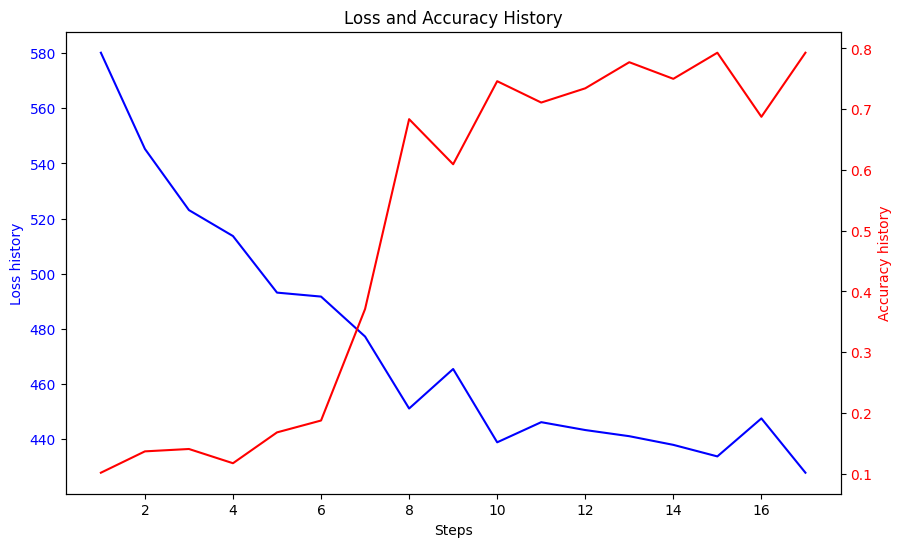

In [12]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

import matplotlib.pyplot as plt
steps = list(range(1, len(loss_history) + 1))

plt.figure(figsize=(10,6))

# Plot the loss history
ax1 = plt.gca()
ax1.plot(steps, loss_history, 'b-')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss history', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Add second plot with compatible scale for accuracy history
ax2 = ax1.twinx()
ax2.plot(steps, accuracy_history, 'r-')
ax2.set_ylabel('Accuracy history', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title to the plot
plt.title('Loss and Accuracy History')

# Display the plot
plt.show()

In [18]:
# Вычислите точность обученной нейросети

# Проведемо розрахунок точності на тестовій вибірці
predictions = neural_net(x_test)
test_accuracy = accuracy(predictions, y_test)

print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.7681


In [10]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?


In [22]:
k=x_test.shape[0]


In [52]:
import random
random_indexes = random.sample(range(k), 5)
print(random_indexes)

[7213, 8070, 9596, 5100, 3762]


Predicted max_value_probability: 0.19565501809120178, digit: 6
Real_digit: 6


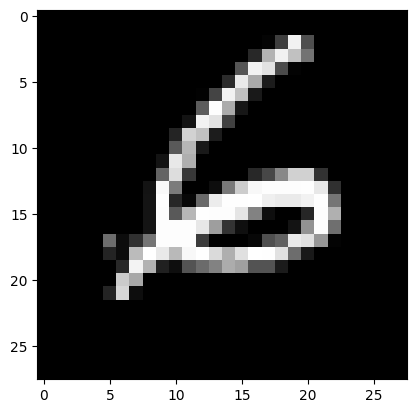

True
-----------------------------------------------------------------------
Predicted max_value_probability: 0.20263709127902985, digit: 3
Real_digit: 3


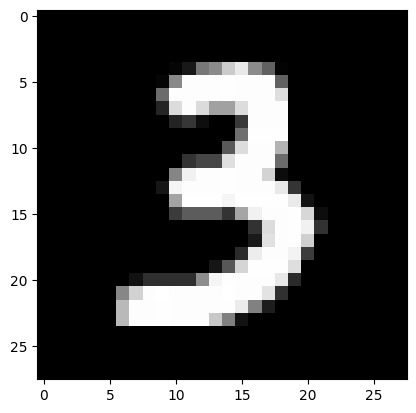

True
-----------------------------------------------------------------------
Predicted max_value_probability: 0.1934834122657776, digit: 8
Real_digit: 8


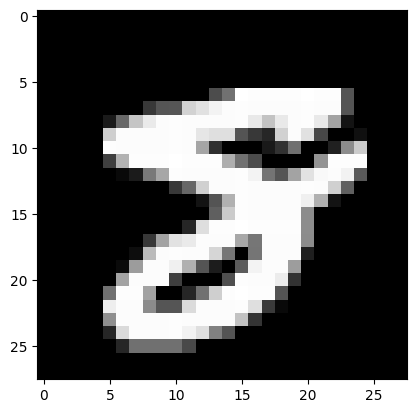

True
-----------------------------------------------------------------------
Predicted max_value_probability: 0.20075540244579315, digit: 4
Real_digit: 9


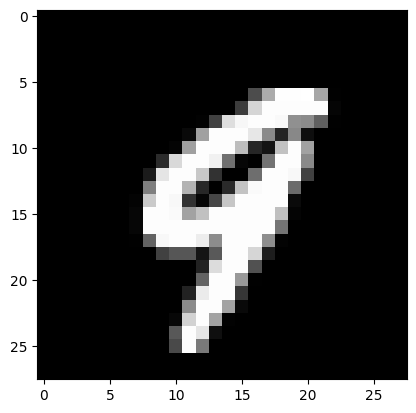

False
-----------------------------------------------------------------------
Predicted max_value_probability: 0.20984236896038055, digit: 6
Real_digit: 6


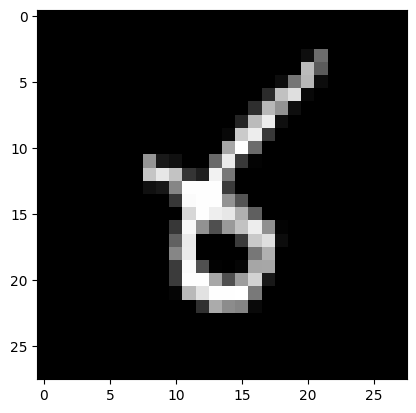

True
-----------------------------------------------------------------------


In [54]:
for index in random_indexes:
  max_value = tf.reduce_max(predictions[index])
  random_list = list(predictions[index].numpy())
  print(f'Predicted max_value_probability: {max_value.numpy()}, digit: {random_list.index(max_value.numpy())}')
  print(f'Real_digit: {y_test[index]}')
  image = x_test[index].reshape(28, 28)
  plt.imshow(image, cmap="gray")
  plt.show()
  print("True" if random_list.index(max_value.numpy()) == y_test[index] else "False")
  print('-----------------------------------------------------------------------')

  #print(predictions[index].numpy())

# ***Висновки:***

1. При правильній архітектурі НН з кожною епохою Loss має зменьшуватися accuracy - збільшуватися 
2. Навчання навіть нескладної НН потребує багато ресурсів.
3. Для того щоб зменьшити кількість ресурсів що використовуються можливо:


*   Зменьшити розмір batch
*   Зменьшити кількість елементів у hidden layers
*   Зменьшити кількість епох тренування

